In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
import numpy as np
from random import randint, uniform
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.metrics.cluster import normalized_mutual_info_score
from datetime import datetime
from sklearn.metrics.cluster import normalized_mutual_info_score


In [0]:
class Kmeans:


    def __init__(self, k, points):
      self.k=k
      self.points = points
      self.centroids=np.full(shape=(self.k,self.points.shape[1]), 
                             fill_value=-1, dtype=np.float64)

      # auxiliary columns: point_id, assigned cluster, distance to cluster
      points_aux=np.full(shape=(self.points.shape[0], 3),fill_value=-1)
      points_aux[:, 0]=np.arange(start=0, stop=self.points.shape[0])
      self.points=np.append(self.points, points_aux, axis=1)
      
      # auxiliary columns: centroid id, counts of assigned points
      centroids_aux=np.full(shape=(self.k, 2),fill_value=0)
      centroids_aux[:, 0]=np.arange(start=0, stop=self.k)
      self.centroids=np.append(self.centroids,centroids_aux,axis=1 )


    # method used in Lloyd and initialization
    def calculate_all_centroids(self):
      for k in range(self.k):
        self.centroids[k,:-2] = \
          self.points[self.points[:,-2]==k][:, :-3].mean(axis=0)
        self.centroids[k,-1] = len(self.points[self.points[:,-2]==k][:, -3])
    
  
   # method used in MacQueen - recalculates old and new centroid
    def calculate_two_centroids(self, point, old_cen, new_cen):

      #update old centroid
      old_cen[:-2] = old_cen[:-2] * old_cen[-1] - point[:-3]                
      old_cen[-1] = old_cen[-1] - 1
      old_cen[:-2] = old_cen[:-2] / old_cen[-1]

      #update new centroid
      new_cen[:-2] = new_cen[:-2] * new_cen[-1] + point[:-3]
      new_cen[-1] = new_cen[-1] + 1
      new_cen[:-2] = new_cen[:-2] / new_cen[-1]

      return old_cen, new_cen
             

    # method to assign point to the nearest centroid. 
    # For macqueen if centroid changed - recalculate 2 centroids
    def assign_clusters(self, points, centroids,macqueen=False):
      for point in points:
        dist_min=np.inf
        old_cen=centroids[int(point[-2]), :]
        new_cen=old_cen.copy()
        for cen in centroids:
            diff = point[:-3] - cen[:-2]
            dist = np.inner(diff,diff)
            if dist < dist_min:
              dist_min = dist
              new_cen = cen
        if new_cen[-2]!=old_cen[-2] and macqueen==True:
            old_cen, new_cen = self.calculate_two_centroids(
                point, old_cen, new_cen)
            centroids[int(old_cen[-2]), :] = old_cen
            centroids[int(new_cen[-2]),:] = new_cen
        point[-2]=new_cen[-2].copy()
        point[-1]=dist_min 

      return points, centroids



    def initialize_clusters(self, method='forgy'):
      self.points[:,-2]=-1
      self.points[:,-1]=-1

      if method=='forgy':
        # assign random cluster to each point
        while any(k not in self.points[:,-2] for k in range(0,self.k)):
          self.points[:,-2]=np.random.randint(
              0, self.k, self.points.shape[0])
        self.calculate_all_centroids()
        
      if method == "kmpp":
        # auxiliary column: probability, create new matrix 'points_aux'for it
        probability=np.full(shape=(self.points.shape[0], 1),fill_value=-1)
        points_aux=np.append(self.points, probability, axis=1)

        for i in range(0,self.k):
            if i == 0:
                # Take one center c1, chosen uniformly at random from X .
                initial=randint(0,self.k)
                self.centroids[i,0:-2] = points_aux[initial,0:-4].copy()
                self.centroids[i,-2]=i
                self.centroids[i,-1]=points_aux.shape[0]
                        
            else:
                # Take a new center ci choosing x ∈ X with probability 
                points_aux[:, :-1], self.centroids[:i,:]=self.assign_clusters(
                    points_aux[:, :-1].copy(), self.centroids[:i,:].copy())
                # calculate square distance
                points_aux[-2]=points_aux[-2].copy()**2
                sum_of_distance=np.sum(points_aux[:,-2])
                points_aux[-1]=points_aux[-2]/sum_of_distance
                # choose  new centroid with probability D^2(x) / sum  x∈X D^2(x)
                select_random=uniform(0,1)
                cumulant=0
                for j in range(points_aux.shape[0]):
                    cumulant = cumulant + points_aux[j, -2]
                    if select_random <= cumulant:
                      self.centroids[i, :-2] = points_aux[j,:-4].copy()
                      break
        # assign points to the nearest clusters and recalculate
        self.points, self.centroids = self.assign_clusters(
              self.points.copy(), self.centroids.copy())
        self.calculate_all_centroids()


    def plot_clusters(self, points, centroids, i):
        #select subset of dataframe with features
        X = points[:,:-3]
        y = points[:,-2]
       
        X_c = centroids[:,:-2]
        y_c = centroids[:,-2]
       
        if X.shape[1] == 2:
            method = 'Plot'
            X_reduced_pca = X
            X_c_reduced_pca = X_c
        else:
            method = 'PCA'
            # calculate PCA Implementation of dim reducition
            pca=PCA(n_components=2, random_state=42)
            pca.fit(X)
            X_reduced_pca = pca.transform(X)
            X_c_reduced_pca = pca.transform(X_c)

        #plotting
        f, (ax1) = plt.subplots(1, 1, figsize=(6,6))
        f.suptitle('Iteration ' + str(i), fontsize=14)

        # scatter plot
        ax1.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1],
                    c=y, cmap='copper', linewidths=4)
        ax1.scatter(X_c_reduced_pca[:,0], X_c_reduced_pca[:,1],
                    c=y_c, marker='x',
                    s=150, cmap='rainbow', linewidths=10)
        ax1.set_title(method, fontsize=14)
        ax1.grid(True)

        plt.show()


    def MacQueen(self, make_plots=False):
        i=0
        while True:
          print('ITERATION', i, datetime.now())
          if make_plots:
            self.plot_clusters(self.points, self.centroids, i)   

          clusters_before = self.points[:,-2].copy()
          self.points, self.centroids = self.assign_clusters(
              self.points.copy(), self.centroids.copy(), macqueen=True)
          clusters_after = self.points[:,-2].copy()
          #check if algorithm converged
          if not any(c_before != c_after for c_before, c_after 
                     in zip(clusters_before,clusters_after)):
            break
          #self.calculate_all_centroids()
          i=i+1


    def Lloyd(self, make_plots=False):
      i=0
      while True:
          print('ITERATION', i, datetime.now())
          if make_plots:
            self.plot_clusters(self.points, self.centroids, i) 

          clusters_before = self.points[:,-2].copy()
          self.points, self.centroids = self.assign_clusters(
              self.points.copy(), self.centroids.copy(),macqueen=False)
          clusters_after = self.points[:,-2].copy()

          #check if algorithm converged
          if not any(c_before != c_after for c_before, c_after 
                     in zip(clusters_before,clusters_after)):
              break
          self.calculate_all_centroids()
          i=i+1
                      

In [353]:
#load the HTRU_2 and skin datasets and save data without classes in separate matrices
file_list = drive.ListFile(
    {'q': "'1y2Ypp16D8hE959IrKCADOvpSHz4Tu2Mz' in parents and trashed=false"}).GetList()
for file in file_list:
  downloaded = drive.CreateFile({'id':file['id']})   
  downloaded.GetContentFile(file['originalFilename'])
  print(file['originalFilename'], file['id'])

data_htru_raw = np.genfromtxt('HTRU_2.csv', delimiter=',')
data_htru=data_htru_raw[:, 0:-1].copy()  

data_skin_raw=np.genfromtxt('Skin_NonSkin.txt', delimiter='\t')[22222:23222,:]
data_skin=data_skin_raw[:, 0:-1].copy()  



Skin_NonSkin.txt 1ZbOE3GxszqNT6iMqxkD_Fdh4y2yzm-hY
HTRU_2.csv 1RPjRbzuf4SZ5VunY1HgQVlWfZ7dpjOTA


In [354]:
data=np.array([[1,1,1.5],[2,1,4.5],[3,2,1.5],[4,2,2.5],[5,2,1.5],[6,2,3.5],[7,3,3.5],[8,4,3.5],[9,5,3.5],[10,2,3.3],[11,5,10],[11,8,8]])[:,1:3]
data


array([[ 1. ,  1.5],
       [ 1. ,  4.5],
       [ 2. ,  1.5],
       [ 2. ,  2.5],
       [ 2. ,  1.5],
       [ 2. ,  3.5],
       [ 3. ,  3.5],
       [ 4. ,  3.5],
       [ 5. ,  3.5],
       [ 2. ,  3.3],
       [ 5. , 10. ],
       [ 8. ,  8. ]])

ITERATION 0 2020-03-23 21:05:53.104444


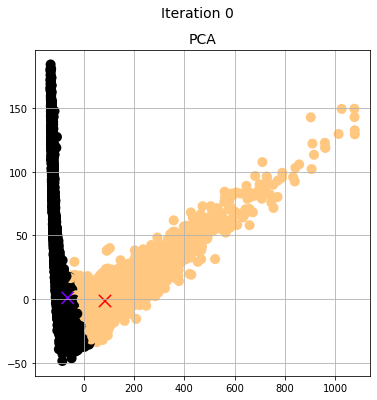

ITERATION 1 2020-03-23 21:05:54.274527


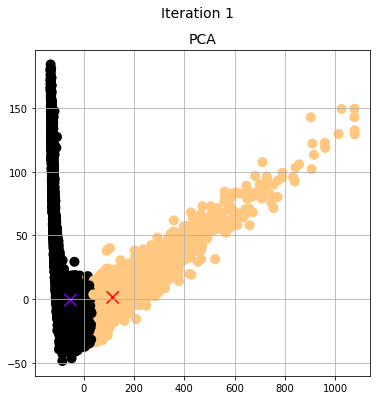

ITERATION 2 2020-03-23 21:05:55.428036


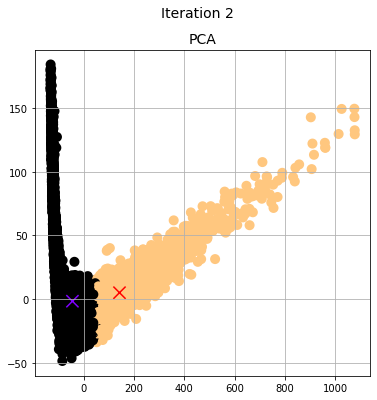

ITERATION 3 2020-03-23 21:05:56.608457


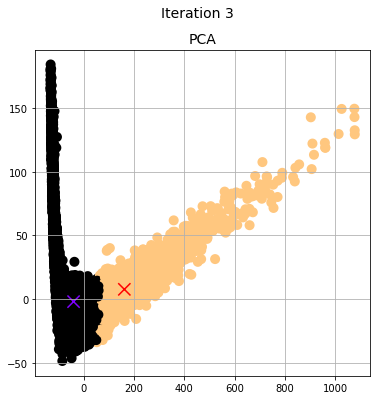

ITERATION 4 2020-03-23 21:05:57.769145


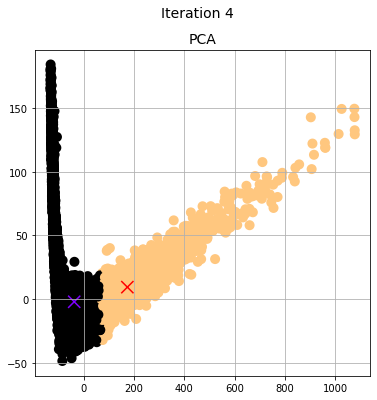

ITERATION 5 2020-03-23 21:05:58.927741


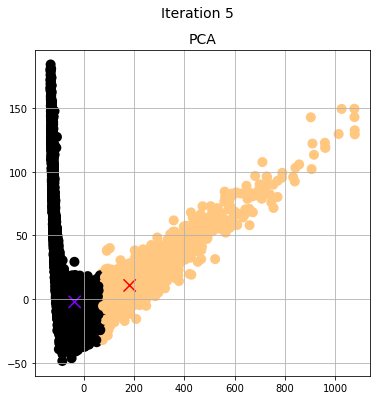

ITERATION 6 2020-03-23 21:06:00.186149


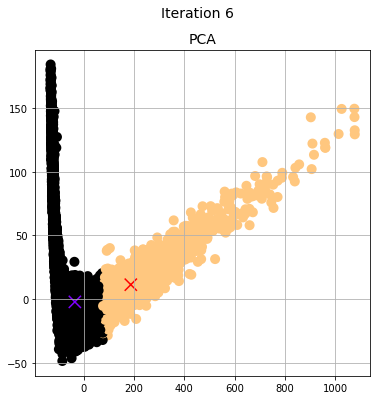

ITERATION 7 2020-03-23 21:06:01.396930


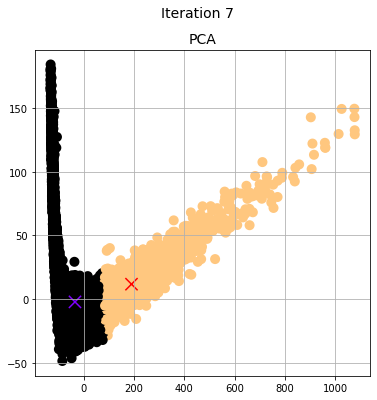

ITERATION 8 2020-03-23 21:06:02.558367


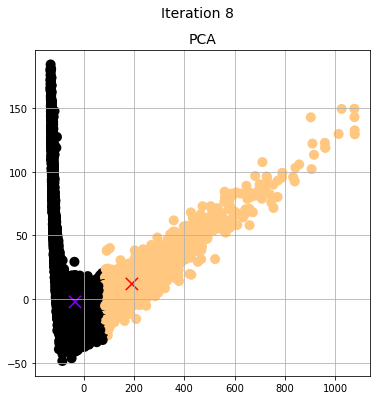

ITERATION 9 2020-03-23 21:06:03.690083


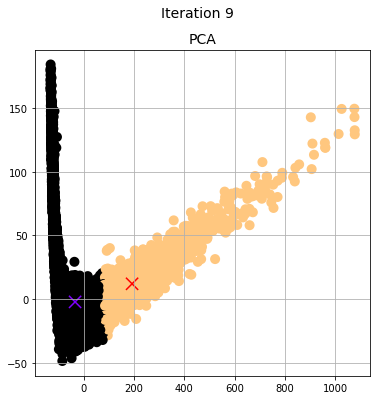

ITERATION 10 2020-03-23 21:06:04.816590


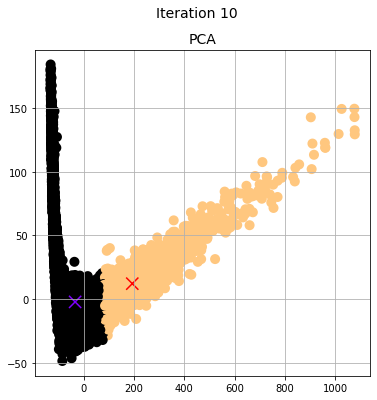

ITERATION 11 2020-03-23 21:06:05.946502


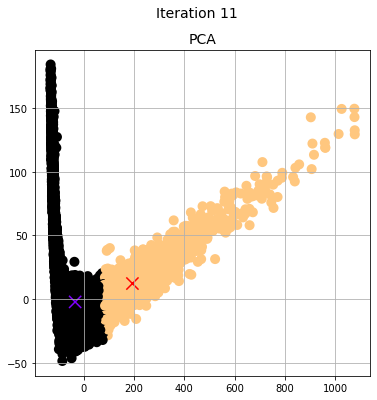

ITERATION 12 2020-03-23 21:06:07.086609


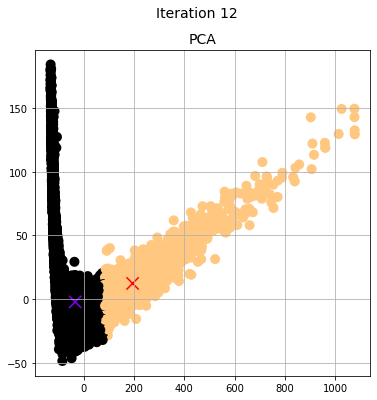

ITERATION 13 2020-03-23 21:06:08.227426


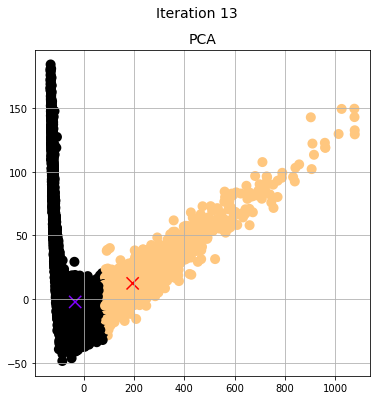

ITERATION 14 2020-03-23 21:06:09.355716


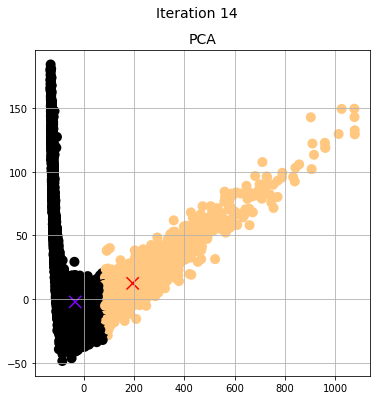

ITERATION 15 2020-03-23 21:06:10.483454


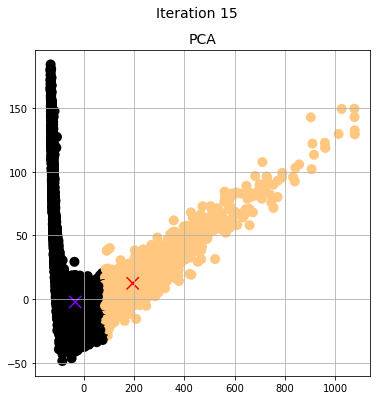

ITERATION 16 2020-03-23 21:06:11.607170


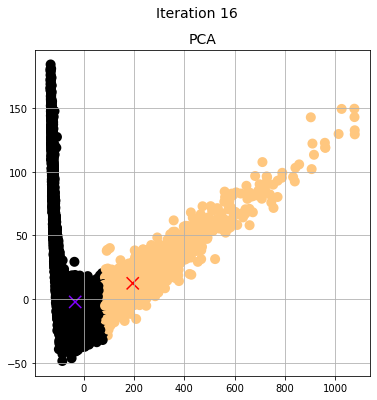

own implementation: 0.02649673183252321


In [356]:
# Own implementation testing:
ex4=Kmeans(2, data_htru)
ex4.initialize_clusters(method='kmpp')
ex4.MacQueen(make_plots=True)
own_NMI= normalized_mutual_info_score(data_htru_raw[:,-1], ex4.points[:,-2])
print('own implementation:',own_NMI)

#Sklearn clustering to compare
#from sklearn.cluster import KMeans
#kmeans = KMeans(n_clusters=2, random_state=34).fit_predict(data_htru)
#sklearn_NMI=normalized_mutual_info_score(data_htru_raw[:,-1], kmeans)

#print('sklearn implementation:',sklearn_NMI)